# Python開発テクニック練習ノートブック
## 2021年度ver

## このノートブックについて
数式の実装には多くの解があります．例えば，行列演算の実装はfor文による実装．行列計算ライブラリによる実装と大きく分けて二通りがあります．

このノートブックでは古川研究室でよく使われる行列演算のテクニックをできるだけ網羅してまとめました．またそれを実際に実行できながら体系的に理解・学習できるようになることを目標に作りました．

## 事前知識
このノートブックでも必要再現の操作は抑えますが，事前知識として以下の本を読むことを推奨します．

[Dropboxにpdf](https://www.dropbox.com/s/7r6cbcux1br1jhb/%E3%82%BC%E3%83%AD%E3%81%8B%E3%82%89%E4%BD%9C%E3%82%8BPython%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0%E5%85%A5%E9%96%80_pass.pdf?dl=0)あります．

- 「ゼロからつくるPython機械学習プログラミング入門」
  - chapter2：Python入門
  - chapter3：数学のおさらい


## 準備
- [Numpy](https://numpy.org/doc/stable/user/index.html)

NumpyはPythonで科学的な計算を行うための基本的なパッケージです。行列計算は機械学習に限らず数値計算の基本であり，Numpyはその行列計算を高速に計算します．

- [Matplotlib]()
MatplotlibはPythonの描画パッケージです． （ここで悩むのは研究の本質的じゃないので困ったら知ってる人に効くことをおすすめします．）

In [5]:
import numpy as np

In [22]:
A = np.eye(5)
print(A)
A.shape

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


(5, 5)

In [41]:
N = 10 # データ数
D = 2 # 次元数
X = np.arange(N*D).reshape(N,D)
print(X, X.shape)

[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]] (10, 2)


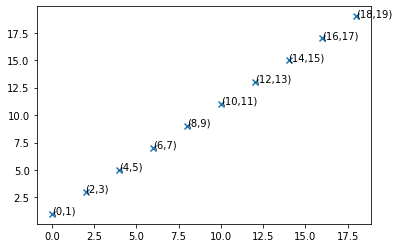

In [46]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], marker='x')
[plt.text(X[n,0], X[n,1], "("+str(X[n,0])+","+str(X[n,1])+")") for n in range(N)]
print("")

## テクニック"
1. ブロードキャスト（Broadcast）
2. メッシュグリッド(Meshgrid)
3. ファンシィインデックス(Fancy index)
4. アーグミン(Argmin)
5. リシェイプ(reshape)
6. アインサム

### 1. Broadcast
Broadcastは，，

詳しい定義は[上島さんの解説記事](https://www.kamishima.net/mlmpyja/nbayes2/broadcasting.html)

In [54]:
I = 3
J = 4
A = np.arange(I)[:, None]
print(A.shape," のshapeの",'\n',A)
B = np.arange(I*J).reshape(I,J)
print(B.shape," のshapeの",'\n',B)
B - A

(3, 1)  のshapeの 
 [[0]
 [1]
 [2]]
(3, 4)  のshapeの 
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


array([[ 0, -1, -2, -3],
       [-3, -4, -5, -6],
       [-6, -7, -8, -9]])

In [56]:
C = np.arange(J)[None, :]
B - C

array([[0, 0, 0, 0],
       [4, 4, 4, 4],
       [8, 8, 8, 8]])

### 2. Meshgrid

### 3. Fancy index

### 4. Argmin

## 実践
1. ノルムと距離
2. 等間隔な座標
3. 描写